# Installing Libraries

In [1]:
%%sh

sudo su 

#Download appropriate package for the OS version
#Choose only ONE of the following, corresponding to your OS version

#RHEL 7 and Oracle Linux 7
curl https://packages.microsoft.com/config/rhel/7/prod.repo > /etc/yum.repos.d/mssql-release.repo

#RHEL 8 and Oracle Linux 8
#curl https://packages.microsoft.com/config/rhel/8/prod.repo > /etc/yum.repos.d/mssql-release.repo

#RHEL 9
#curl https://packages.microsoft.com/config/rhel/9.0/prod.repo > /etc/yum.repos.d/mssql-release.repo

exit

sudo yum remove unixODBC-utf16 unixODBC-utf16-devel #to avoid conflicts
sudo ACCEPT_EULA=Y yum install -y msodbcsql17
# optional: for bcp and sqlcmd
sudo ACCEPT_EULA=Y yum install -y mssql-tools
echo 'export PATH="$PATH:/opt/mssql-tools/bin"' >> ~/.bashrc
source ~/.bashrc
# optional: for unixODBC development headers
sudo yum install -y unixODBC-devel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   413  100   413    0     0   7497      0 --:--:-- --:--:-- --:--:--     0 0    0     0      0      0 --:--:-- --:--:-- --:--:--     0--  7375


Loaded plugins: dkms-build-requires, extras_suggestions, kernel-livepatch,
              : langpacks, priorities, update-motd, versionlock


No Match for argument: unixODBC-utf16
No Match for argument: unixODBC-utf16-devel


No Packages marked for removal
Loaded plugins: dkms-build-requires, extras_suggestions, kernel-livepatch,
              : langpacks, priorities, update-motd, versionlock


https://download.docker.com/linux/centos/2/x86_64/stable/repodata/repomd.xml: [Errno 14] HTTPS Error 404 - Not Found
Trying other mirror.


67 packages excluded due to repository priority protections
Package msodbcsql17-17.10.6.1-1.x86_64 already installed and latest version
Nothing to do
Loaded plugins: dkms-build-requires, extras_suggestions, kernel-livepatch,
              : langpacks, priorities, update-motd, versionlock


https://download.docker.com/linux/centos/2/x86_64/stable/repodata/repomd.xml: [Errno 14] HTTPS Error 404 - Not Found
Trying other mirror.


67 packages excluded due to repository priority protections
Package mssql-tools-17.10.1.1-1.x86_64 already installed and latest version
Nothing to do
Loaded plugins: dkms-build-requires, extras_suggestions, kernel-livepatch,
              : langpacks, priorities, update-motd, versionlock


https://download.docker.com/linux/centos/2/x86_64/stable/repodata/repomd.xml: [Errno 14] HTTPS Error 404 - Not Found
Trying other mirror.


67 packages excluded due to repository priority protections
Package unixODBC-devel-2.3.1-15.amzn2.x86_64 already installed and latest version
Nothing to do


# Installing libraries

In [4]:
!pip install polars -q 

# Connecting to database

In [3]:
import re
import pyodbc

In [4]:
file_path = '/home/ec2-user/SageMaker/db-credentials.txt'

with open(file_path, 'r') as file:
    # Code to parse the data will go here
    file_contents = file.read()

# Remove newlines and extra spaces
cleaned_string = file_contents.replace('\n', '').strip()

# Extract variable-value pairs using regular expressions
pattern = r'"([^"]+)": "([^"]+)"'
pairs = re.findall(pattern, cleaned_string)

parsed_data = {}

for variable, data in pairs:
    parsed_data[variable] = data

In [5]:
### This example shows how to view tables in the AAOCHIN2023 database. 
raw_db = 'AAOCHIN2023' 
raw_connection_string = "DRIVER={ODBC Driver 17 for SQL Server};" + \
                    "SERVER=" + parsed_data['host'] + ',' + parsed_data['port'] + ';' + \
                    "DATABASE=" + raw_db + ';' + \
                    "UID=" + parsed_data['username'] + ';' + \
                    "PWD={" + parsed_data['password'] + "};"
raw_conn = pyodbc.connect(raw_connection_string, trusted_connection = 'no')
raw_cursor = raw_conn.cursor()

In [6]:
#### CHECK IF DATABASE CURSOR IS WORKING
raw_cursor.execute('''
SELECT name AS TABLE_NAME
FROM sys.views
''')
for row in raw_cursor:
    print(row[0])

OBSERVATION_FACT
PATIENT_DIMENSION
PROVIDER_DIMENSION
VISIT_DIMENSION
ZCTA_CVS
SIDECAR_FACILITIES
CONCEPT_DIMENSION
I2B2


# Importing required libraries

In [13]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# code

# Metformin analysis

In [ ]:
medications_df = pl.scan_parquet("Determine_cohort_medications_active_ing.parquet")

In [ ]:
medications_df.filter(pl.col('Active_ingrident')== 'metformin').collect()

In [ ]:
np.unique(medications_df.filter(pl.col('Active_ingrident')== 'metformin').collect()['Medication_Name'])

In [ ]:
np.unique(medications_df.filter(pl.col('Active_ingrident')== 'metformin').collect()['RxNorm'])

In [ ]:
pids_with_metformin = np.unique(medications_df.filter(pl.col('Active_ingrident')== 'metformin').collect()['PATIENT_NUM'])

In [ ]:
len(pids_with_metformin)

In [ ]:
## Target data
target_df = pl.scan_parquet('Determine_Cohort_with_labels_OutcomeDate.parquet')

In [ ]:
req_target_df = target_df.filter(pl.col('PATIENT_NUM').is_in(pids_with_metformin)).collect()

In [ ]:
np.unique(req_target_df['Outcome'].to_list(),return_counts = True) ## 4867 who dont have diabetes used metformin hydrochloride

In [ ]:
target_df.filter(pl.col('PATIENT_NUM').is_in(pids_with_metformin)).filter(pl.col('Outcome')==1).collect()

## Type 1 and Gestational diabetes mellitus 

In [16]:
import pickle
with open('./Determine_models_running_folder/catboost_false_positives_pids_test.pkl', 'rb') as file: 
    data_test_pids_fp = pickle.load(file) 

In [17]:
len(data_test_pids_fp)

54194

In [19]:
data_test_pids_fp[:10]

[520088,
 2702717,
 1195023,
 7836063,
 7244562,
 5177246,
 280011,
 7393359,
 6598902,
 8032692]

In [10]:
patient_nums_str = ', '.join(map(str, data_test_pids_fp[10000:20000]))

In [ ]:
test_df = pl.read_database(f""" 
    SELECT ob.PATIENT_NUM, ob.CONCEPT_CD, ob.start_date
    FROM AAOCHIN2023.S348.OBSERVATION_FACT ob     
    WHERE ob.PATIENT_NUM IN ({patient_nums_str})
    AND (ob.CONCEPT_CD LIKE 'ICD10CM:E11%'
        OR ob.CONCEPT_CD LIKE 'ICD10CM:E10%'
         OR ob.CONCEPT_CD = 'ICD10CM:O24.429'
    ); 
""", connection=raw_cursor)

# test_df = pl.read_database(f""" 
#     select * from S348.dbo.DETERMINE_OCHIN_COHORT where PATIENT_NUM IN ({patient_nums_str}); 
# """, connection=raw_cursor)

In [ ]:
test_df

In [ ]:
len(np.unique(test_df['PATIENT_NUM'].to_list()))

In [18]:
cohort_df = pl.read_database(f""" 
    select * from S348.dbo.DETERMINE_OCHIN_COHORT where PATIENT_NUM IN ({patient_nums_str}); 
""", connection=raw_cursor)

In [ ]:
1098665 in data_test_pids_fp

In [21]:
cohort_df.sort('PATIENT_NUM').filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fp)).filter(pl.col('Outcome') == 1)

PATIENT_NUM,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD
i64,datetime[μs],datetime[μs],i64,i64,datetime[μs],str
2085983,2019-04-08 00:00:00,2021-12-17 00:00:00,81,1,null,"""44224"""
2255770,2018-09-29 00:00:00,2020-02-17 00:00:00,58,1,null,"""02121"""
2407886,2019-04-18 00:00:00,2020-11-19 00:00:00,72,1,null,"""55404"""
2563031,2019-01-17 00:00:00,2021-03-16 00:00:00,58,1,null,"""97206"""
2812882,2019-04-22 00:00:00,2022-05-25 00:00:00,37,1,null,"""55414"""
…,…,…,…,…,…,…
10025135,2018-11-08 00:00:00,2022-03-16 00:00:00,62,1,null,"""02532"""
10625151,2019-01-30 00:00:00,2021-08-25 00:00:00,69,1,null,"""98057"""
11090904,2019-04-11 00:00:00,2022-07-29 00:00:00,62,1,null,"""60618"""


In [ ]:
test_df = pl.read_database(f""" 
    SELECT ob.PATIENT_NUM, ob.CONCEPT_CD, ob.start_date
    FROM AAOCHIN2023.S348.OBSERVATION_FACT ob     
    WHERE ob.PATIENT_NUM IN (10502111)
    AND (ob.CONCEPT_CD LIKE 'ICD10CM:E11%'
        OR ob.CONCEPT_CD LIKE 'ICD10CM:E10%'
         OR ob.CONCEPT_CD = 'ICD10CM:O24.429'
    ); 
""", connection=raw_cursor)
test_df

In [ ]:
len(np.unique(test_df['PATIENT_NUM'].to_list()))

## False positives and False negatives distribution

In [6]:
import pickle
prefix_path = './Determine_models_running_folder/FP_FN_Determine_joined_med_usage_lab_median_domain_expert_diag_phemap_without_icd10z_bmi_bp_cvs_ordinal_nominal_encoded/'
# Open the file in binary mode 
with open(prefix_path +'catboost_false_positives_pids_test.pkl', 'rb') as file: 
    data_test_pids_fp = pickle.load(file) 
    
with open(prefix_path +'catboost_true_negatives_pids_test.pkl', 'rb') as file: 
    data_test_pids_tn = pickle.load(file) 

# Open the file in binary mode 
with open(prefix_path +'catboost_false_negatives_pids_test.pkl', 'rb') as file: 
    data_test_pids_fn = pickle.load(file) 

with open(prefix_path +'catboost_true_positives_pids_test.pkl', 'rb') as file: 
    data_test_pids_tp = pickle.load(file) 

# Feature missingness

In [48]:
class modeling_config:
    labs_latest_path = './Determine_Cohort_files_pivot/Determine_lab_results_median_domain_expert_pivot.parquet'
#     labs_mean_path =
#     labs_temporal_path =
    meds_path = './Determine_Cohort_files_pivot/Determine_medications_active_ingredients_pivot.parquet'
    diag_path = './Determine_Cohort_files_pivot/Determine_diagnoses_phemap_pivot_with_icd10z.parquet'
    demo_path = './Determine_modeling_datasets/Determine_modeling_demographics_data.parquet'
    target_path = 'Determine_Cohort_with_labels_OutcomeDate.parquet'
    bmi_path = './Determine_cohort_files/Determine_modeling_bmi_data_manual.parquet'
    dia_bp_path = './Determine_cohort_files/Determine_modeling_diastolic_bp_data.parquet'
    sys_bp_path = './Determine_cohort_files/Determine_modeling_systolic_bp_data.parquet'
    association_threshold = 20

In [50]:
labresults_df = pl.read_parquet(modeling_config.labs_latest_path)
medications_pivot_df = pl.read_parquet(modeling_config.meds_path)
diag_pivot_df = pl.read_parquet(modeling_config.diag_path)
bmi_df =  pl.read_parquet(modeling_config.bmi_path)
sys_df =  pl.read_parquet(modeling_config.dia_bp_path)
dia_df =  pl.read_parquet(modeling_config.sys_bp_path)

In [51]:
labresults_df = labresults_df.fill_null(-100)

In [52]:
def count_values_not_zero(row:dict):
    return sum(list(row.values()))

def count_values_not_neg_100(row: dict):
    return sum(1 for value in row.values() if value != -100)

In [53]:
all_pids = list(set(labresults_df['PATIENT_NUM']) |set(medications_pivot_df['PATIENT_NUM']) | set(diag_pivot_df['PATIENT_NUM']))

In [54]:
all_pids_df = pl.DataFrame({'PATIENT_NUM':all_pids})

In [55]:
labs_feat_count_df = labresults_df.with_columns(pl.struct(pl.all().exclude('PATIENT_NUM')).map_elements(count_values_not_neg_100, return_dtype =pl.Int32).alias('lab_feature_count')).select(['PATIENT_NUM','lab_feature_count'])
med_feat_count_df = medications_pivot_df.with_columns(pl.struct(pl.all().exclude('PATIENT_NUM')).map_elements(count_values_not_zero, return_dtype =pl.Int32).alias('med_feature_count')).select(['PATIENT_NUM','med_feature_count'])
dx_feat_count_df = diag_pivot_df.with_columns(pl.struct(pl.all().exclude('PATIENT_NUM')).map_elements(count_values_not_zero, return_dtype =pl.Int32).alias('dx_feature_count')).select(['PATIENT_NUM','dx_feature_count'])

In [56]:
feature_missing_df = all_pids_df.join(labs_feat_count_df, on  = 'PATIENT_NUM',how = 'left').join(med_feat_count_df, on  = 'PATIENT_NUM',how = 'left').join(dx_feat_count_df, on  = 'PATIENT_NUM',how = 'left')

In [57]:
feature_missing_df = feature_missing_df.fill_null(0)

In [58]:
feature_missing_df = feature_missing_df.with_columns(pl.sum_horizontal(pl.all().exclude('PATIENT_NUM')).alias('Total_Feature_Count'))

In [59]:
feature_missing_df

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count
i64,i32,i32,i32,i32
8388608,36,0,1,37
8388613,0,0,1,1
8388614,0,0,1,1
4194311,44,2,7,53
8388618,0,0,1,1
…,…,…,…,…
4194278,0,0,4,4
8388590,0,0,2,2
4194287,0,2,3,5


In [ ]:
feature_missing_df.filter(pl.col('Total_Feature_Count')==1).filter(pl.col('Outcome')==1)

### Joining with bmi, systolic, diastolic bp, target  and demographics data

In [62]:
target_df = pl.read_parquet(modeling_config.target_path)
feature_missing_df = feature_missing_df.join(target_df, on = 'PATIENT_NUM',how = 'left')

In [63]:
np.unique(target_df['Outcome'], return_counts = True)

(array([0, 1]), array([1004264,   60204]))

In [64]:
demo_df = pl.read_parquet(modeling_config.demo_path)
feature_missing_df = feature_missing_df.join(demo_df, left_on = 'PATIENT_NUM',right_on = 'Patient_num',how = 'left')

In [65]:
feature_missing_df = feature_missing_df.join(bmi_df, left_on = 'PATIENT_NUM',right_on = 'PATIENT_NUM',how = 'left')

In [66]:
feature_missing_df = feature_missing_df.join(dia_df, left_on = 'PATIENT_NUM',right_on = 'PATIENT_NUM',how = 'left')
feature_missing_df = feature_missing_df.join(sys_df, left_on = 'PATIENT_NUM',right_on = 'PATIENT_NUM',how = 'left')

In [67]:
demo_df.filter(pl.col('Patient_num') == 12404732)

Patient_num,Sex_CD,Race_CD,Hispanic_CD,Gender_CD
i64,str,str,str,str
12404732,"""F""","""05""","""N""","""W"""


In [68]:
len(target_df)

1064468

In [69]:
feature_missing_df

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32
8388608,36,0,1,37,2017-03-30 00:00:00,null,51,0,null,"""94619""","""M""","""02""","""N""","""M""",66.0,162.0,26.144629,98.5,79.800003
8388613,0,0,1,1,2016-10-17 00:00:00,null,54,0,null,"""94509""","""F""","""03""","""N""","""W""",null,null,null,null,null
8388614,0,0,1,1,2017-01-05 00:00:00,null,25,0,null,"""94803""","""M""","""UN""","""N""","""M""",null,null,null,null,null
4194311,44,2,7,53,2016-12-08 00:00:00,null,29,0,null,"""90805""","""F""","""UN""","""N""","""UN""",66.0,270.899994,43.719628,98.25,79.658333
8388618,0,0,1,1,2017-01-04 00:00:00,null,33,0,null,"""55407""","""F""","""05""","""Y""","""W""",63.5,138.0,24.059519,106.666664,106.666664
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4194278,0,0,4,4,2016-05-13 00:00:00,null,36,0,null,"""80134""","""M""","""05""","""N""","""UN""",null,null,null,null,null
8388590,0,0,2,2,2017-03-02 00:00:00,null,28,0,null,"""55407""","""F""","""05""","""N""","""W""",71.0,208.0,29.006943,103.5,103.5
4194287,0,2,3,5,2017-01-03 00:00:00,null,56,0,null,"""27925""","""F""","""05""","""N""","""W""",67.0,139.699997,21.877723,110.280006,101.900002


In [9]:
pids_feature_1_outcome_1 = feature_missing_df.filter((pl.col('Total_Feature_Count')==1) &
                                                     (pl.col('BMI').is_null()) &
                                                      (pl.col('median_systolic_value').is_null())
                                                    ).filter(pl.col('Outcome')==1)['PATIENT_NUM']
pids_feature_1_outcome_0 = feature_missing_df.filter((pl.col('Total_Feature_Count')==1) &
                                                     (pl.col('BMI').is_null()) &
                                                      (pl.col('median_systolic_value').is_null())
                                                    ).filter(pl.col('Outcome')==0)['PATIENT_NUM']

feature_missing_df.filter((pl.col('Total_Feature_Count')==1) &
                                                     (pl.col('BMI').is_null()) &
                                                      (pl.col('median_systolic_value').is_null())
                                                    ).sort('PATIENT_NUM')

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32
561,0,1,0,1,2016-07-21 00:00:00,null,37,0,null,"""77063""","""F""","""03""","""N""","""W""",null,null,null,null,null
891,0,1,0,1,2016-09-26 00:00:00,null,28,0,null,"""53212""","""F""","""03""","""N""","""UN""",null,null,null,null,null
953,0,1,0,1,2016-06-13 00:00:00,null,58,0,null,"""44120""","""M""","""02""","""N""","""UN""",null,null,null,null,null
1010,0,0,1,1,2017-03-07 00:00:00,null,61,0,null,"""97222""","""M""","""05""","""N""","""UN""",null,null,null,null,null
1262,0,0,1,1,2016-09-15 00:00:00,null,56,0,null,"""77040""","""F""","""UN""","""UN""","""UN""",null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12402076,0,0,1,1,2016-08-26 00:00:00,null,61,0,null,"""94952""","""F""","""05""","""N""","""W""",null,null,null,null,null
12403413,0,0,1,1,2016-08-13 00:00:00,null,43,0,null,"""95407""","""F""","""05""","""Y""","""W""",null,null,null,null,null
12403874,0,0,1,1,2016-04-07 00:00:00,null,25,0,null,"""98155""","""F""","""03""","""N""","""UN""",null,null,null,null,null


In [71]:
feature_missing_df.write_parquet('Determine_missing_features_OCHIN.parquet')

# Loading feature missing df

In [ ]:
feature_missing_df = pl.read_parquet('Determine_missing_features_OCHIN.parquet')

# Encounter counter

In [11]:
feature_missing_df

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32
8388608,36,0,1,37,2017-03-30 00:00:00,null,51,0,null,"""94619""","""M""","""02""","""N""","""M""",66.0,162.0,26.144629,98.5,79.800003
8388613,0,0,1,1,2016-10-17 00:00:00,null,54,0,null,"""94509""","""F""","""03""","""N""","""W""",null,null,null,null,null
8388614,0,0,1,1,2017-01-05 00:00:00,null,25,0,null,"""94803""","""M""","""UN""","""N""","""M""",null,null,null,null,null
4194311,44,2,7,53,2016-12-08 00:00:00,null,29,0,null,"""90805""","""F""","""UN""","""N""","""UN""",66.0,270.899994,43.719628,98.25,79.658333
8388618,0,0,1,1,2017-01-04 00:00:00,null,33,0,null,"""55407""","""F""","""05""","""Y""","""W""",63.5,138.0,24.059519,106.666664,106.666664
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4194278,0,0,4,4,2016-05-13 00:00:00,null,36,0,null,"""80134""","""M""","""05""","""N""","""UN""",null,null,null,null,null
8388590,0,0,2,2,2017-03-02 00:00:00,null,28,0,null,"""55407""","""F""","""05""","""N""","""W""",71.0,208.0,29.006943,103.5,103.5
4194287,0,2,3,5,2017-01-03 00:00:00,null,56,0,null,"""27925""","""F""","""05""","""N""","""W""",67.0,139.699997,21.877723,110.280006,101.900002


In [43]:
feature_missing_df.filter(pl.col('Total_Feature_Count')==1)

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32
8388613,0,0,1,1,2016-10-17 00:00:00,null,54,0,null,"""94509""","""F""","""03""","""N""","""W""",null,null,null,null,null
8388614,0,0,1,1,2017-01-05 00:00:00,null,25,0,null,"""94803""","""M""","""UN""","""N""","""M""",null,null,null,null,null
8388618,0,0,1,1,2017-01-04 00:00:00,null,33,0,null,"""55407""","""F""","""05""","""Y""","""W""",63.5,138.0,24.059519,106.666664,106.666664
4194385,0,1,0,1,2016-08-11 00:00:00,null,18,0,null,"""97754""","""F""","""05""","""N""","""W""",null,null,null,null,null
8388719,0,0,1,1,2017-01-30 00:00:00,null,24,0,null,"""98121""","""F""","""05""","""N""","""W""",null,null,null,93.0,93.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8388234,0,0,1,1,2016-09-08 00:00:00,null,18,0,null,"""93304""","""M""","""03""","""N""","""M""",66.0,119.599998,19.301837,102.866669,102.866669
8388365,0,0,1,1,2017-03-15 00:00:00,null,43,0,null,"""94609""","""F""","""05""","""N""","""W""",69.0,134.5,19.860009,115.0,105.833336
8388376,0,0,1,1,2017-01-19 00:00:00,null,40,0,null,"""08330""","""F""","""03""","""N""","""W""",null,null,null,null,null


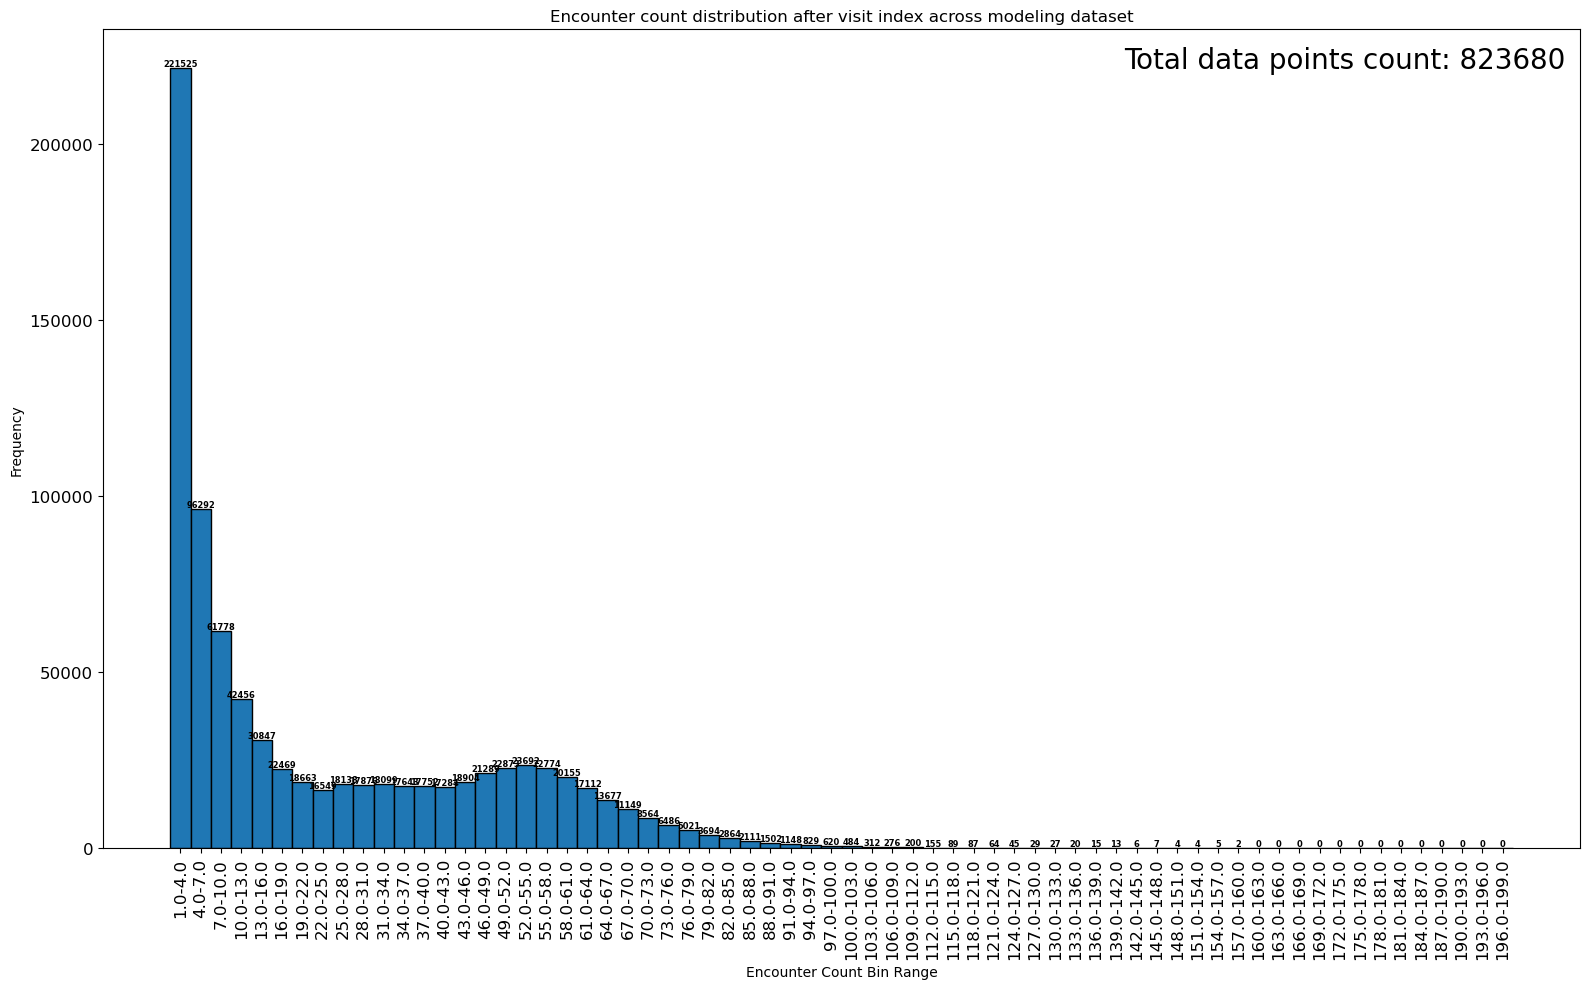

In [33]:
data = feature_missing_df['Total_Feature_Count'].to_list()

# Determine the range of the data
data_min = int(np.floor(min(data)))
data_max = int(np.ceil(max(data)))

# Create integer bin edges
bins = range(data_min, data_max+2, 3)  # +2 because range is exclusive of the upper bound


plt.figure(figsize=(16,10))
# Histogram
counts, bin_edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Prepare custom labels: "left-right" for each bin
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Bin centers for placing the x-ticks
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set the x-ticks and labels
plt.xticks(bin_centers, bin_labels, rotation=90)

# Add count labels above each bar
for count, center in zip(counts, bin_centers):
    plt.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=6, fontweight='bold')

plt.text(
    0.99, 0.98, 
    f'Total data points count: {len(data)}',
    fontsize=20,
    ha='right',
    va='top',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
plt.xlabel("Encounter Count Bin Range")
plt.ylabel("Frequency")
plt.title('Encounter count distribution after visit index across modeling dataset')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

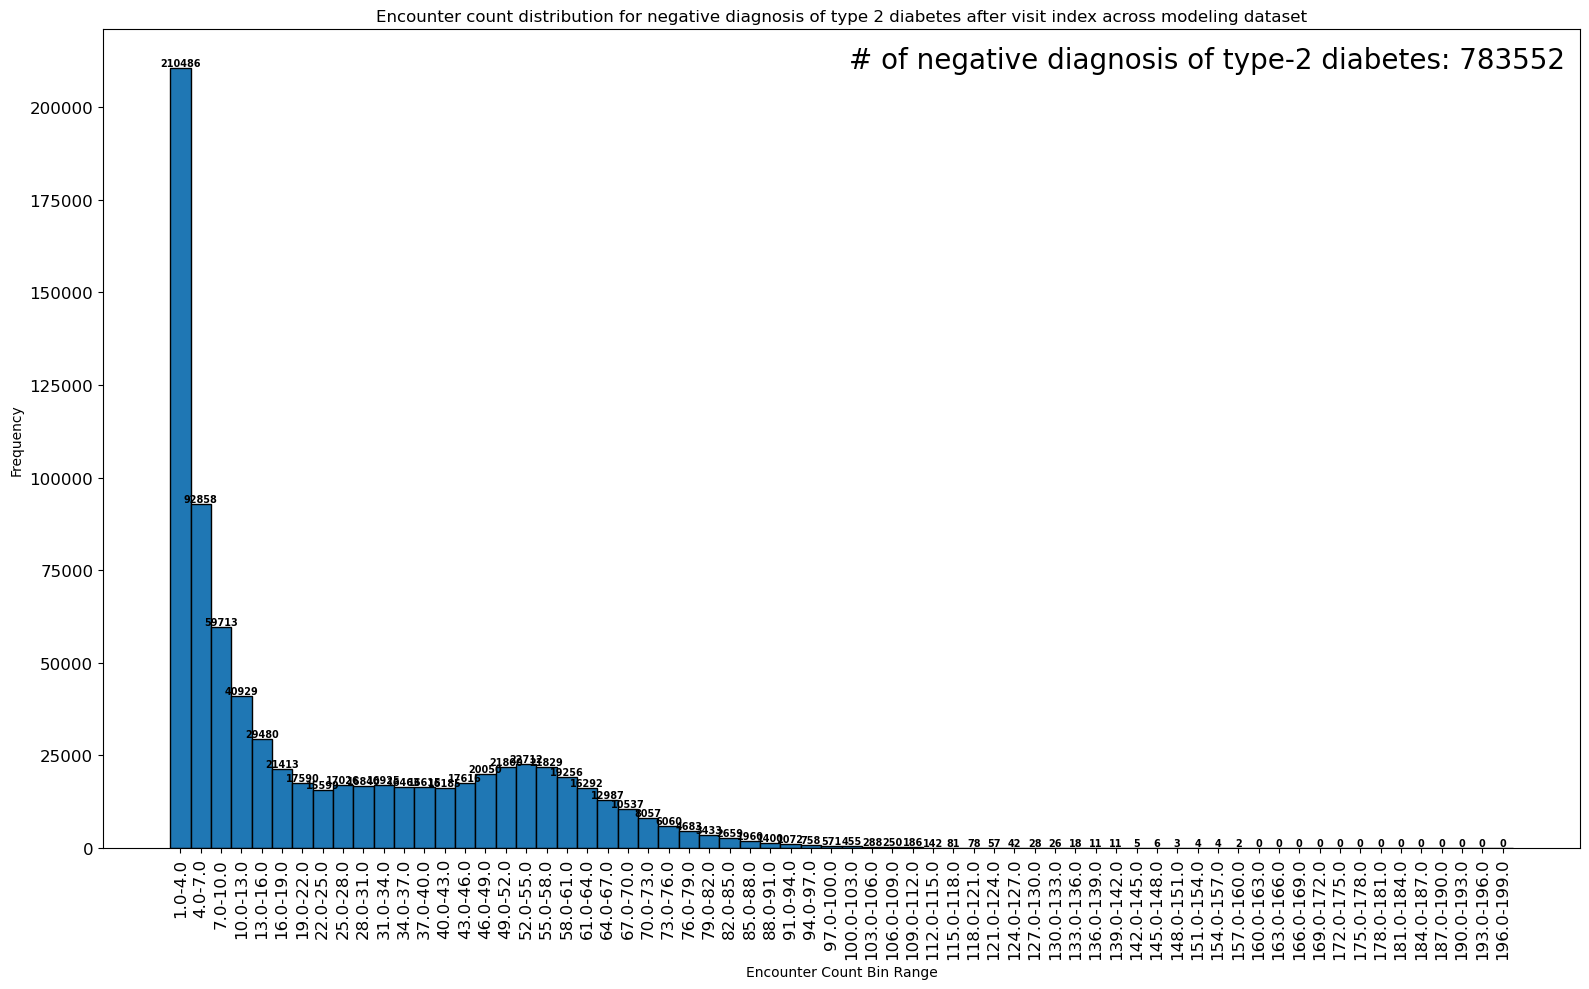

In [53]:
data = feature_missing_df.filter(pl.col('Outcome')==0)['Total_Feature_Count'].to_list()

# Determine the range of the data
data_min = int(np.floor(min(data)))
data_max = int(np.ceil(max(data)))

# Create integer bin edges
bins = range(data_min, data_max+2, 3)  # +2 because range is exclusive of the upper bound


plt.figure(figsize=(16,10))
# Histogram
counts, bin_edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Prepare custom labels: "left-right" for each bin
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Bin centers for placing the x-ticks
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set the x-ticks and labels
plt.xticks(bin_centers, bin_labels, rotation=90)

# Add count labels above each bar
for count, center in zip(counts, bin_centers):
    plt.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.text(
    0.99, 0.98, 
    f'# of negative diagnosis of type-2 diabetes: {len(data)}',
    fontsize=20,
    ha='right',
    va='top',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
plt.xlabel("Encounter Count Bin Range")
plt.ylabel("Frequency")
plt.title('Encounter count distribution for negative diagnosis of type 2 diabetes after visit index across modeling dataset')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

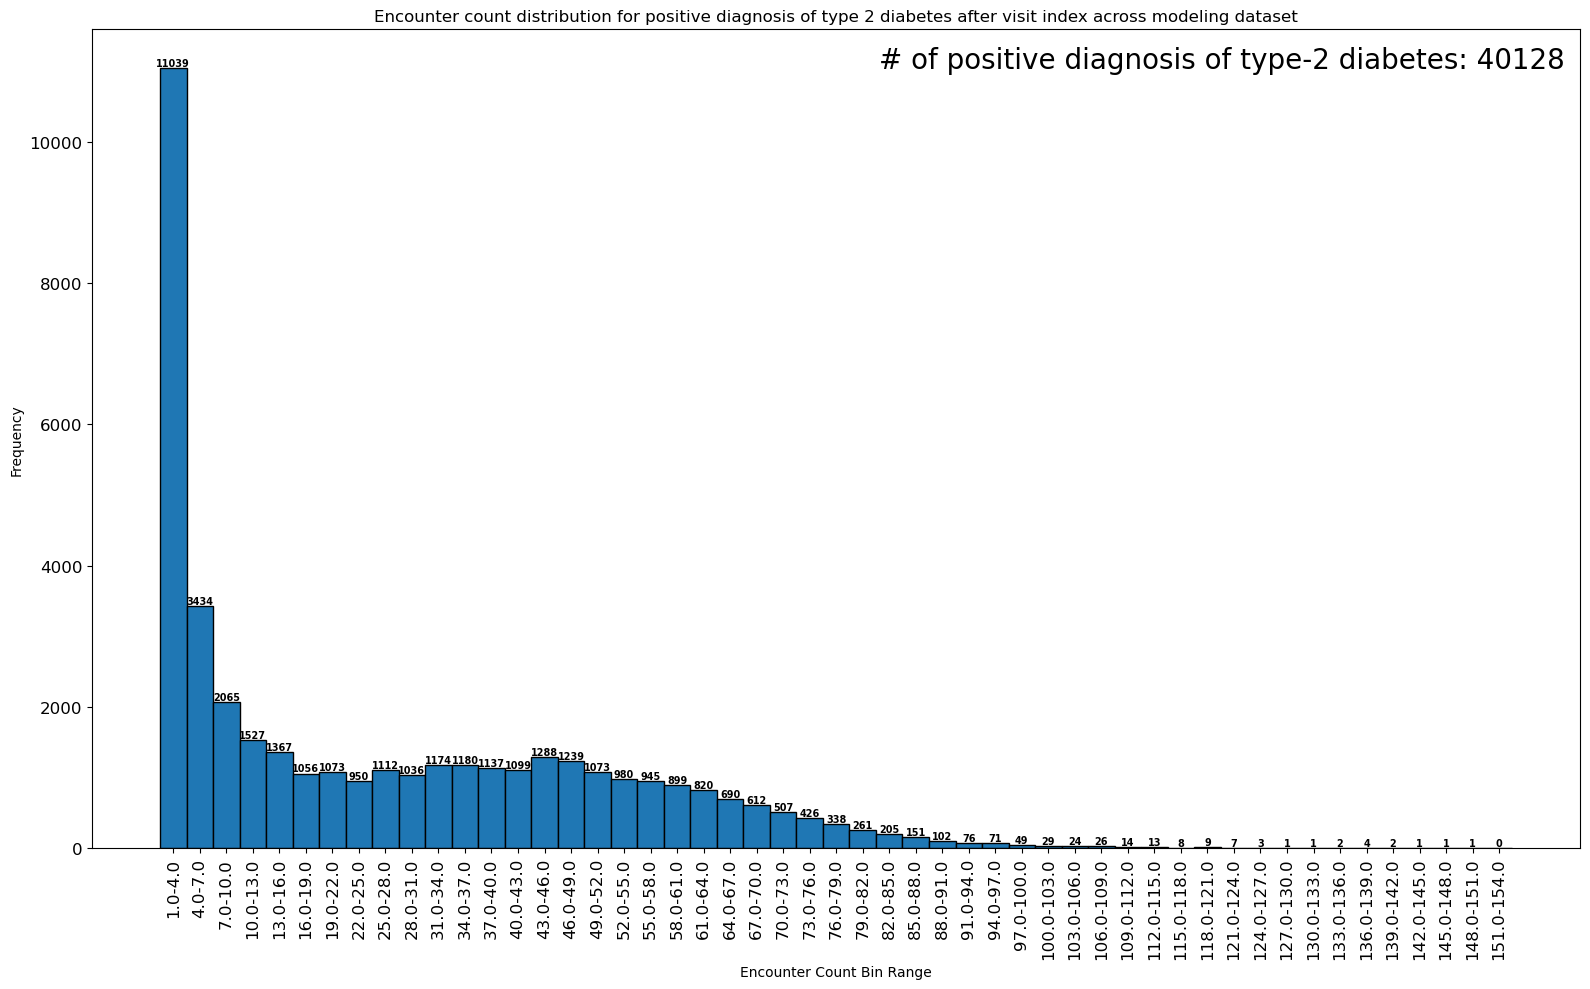

In [52]:
data = feature_missing_df.filter(pl.col('Outcome')==1)['Total_Feature_Count'].to_list()

# Determine the range of the data
data_min = int(np.floor(min(data)))
data_max = int(np.ceil(max(data)))

# Create integer bin edges
bins = range(data_min, data_max+2, 3)  # +2 because range is exclusive of the upper bound


plt.figure(figsize=(16,10))
# Histogram
counts, bin_edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Prepare custom labels: "left-right" for each bin
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Bin centers for placing the x-ticks
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set the x-ticks and labels
plt.xticks(bin_centers, bin_labels, rotation=90)

# Add count labels above each bar
for count, center in zip(counts, bin_centers):
    plt.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.text(
    0.99, 0.98, 
    f'# of positive diagnosis of type-2 diabetes: {len(data)}',
    fontsize=20,
    ha='right',
    va='top',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
plt.xlabel("Encounter Count Bin Range")
plt.ylabel("Frequency")
plt.title('Encounter count distribution for positive diagnosis of type 2 diabetes after visit index across modeling dataset')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Missing features in False positives and False negatives

In [8]:
feature_missing_df

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32
8388608,36,0,1,37,2017-03-30 00:00:00,null,51,0,null,"""94619""","""M""","""02""","""N""","""M""",66.0,162.0,26.144629,98.5,79.800003
8388613,0,0,1,1,2016-10-17 00:00:00,null,54,0,null,"""94509""","""F""","""03""","""N""","""W""",null,null,null,null,null
8388614,0,0,1,1,2017-01-05 00:00:00,null,25,0,null,"""94803""","""M""","""UN""","""N""","""M""",null,null,null,null,null
4194311,44,2,7,53,2016-12-08 00:00:00,null,29,0,null,"""90805""","""F""","""UN""","""N""","""UN""",66.0,270.899994,43.719628,98.25,79.658333
8388618,0,0,1,1,2017-01-04 00:00:00,null,33,0,null,"""55407""","""F""","""05""","""Y""","""W""",63.5,138.0,24.059519,106.666664,106.666664
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4194278,0,0,4,4,2016-05-13 00:00:00,null,36,0,null,"""80134""","""M""","""05""","""N""","""UN""",null,null,null,null,null
8388590,0,0,2,2,2017-03-02 00:00:00,null,28,0,null,"""55407""","""F""","""05""","""N""","""W""",71.0,208.0,29.006943,103.5,103.5
4194287,0,2,3,5,2017-01-03 00:00:00,null,56,0,null,"""27925""","""F""","""05""","""N""","""W""",67.0,139.699997,21.877723,110.280006,101.900002


In [60]:
feature_missing_df.filter(pl.col('PATIENT_NUM')==700490)

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count
i64,i32,i32,i32,i32
700490,0,11,6,17


In [41]:
feature_missing_df.filter((pl.col('Sex_CD').is_null()) & 
                          (pl.col('BMI').is_null())  )

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str,f32,f32,f64,f32,f32


In [46]:
feature_missing_df.filter((pl.col('Sex_CD').is_null()) & 
                          (pl.col('BMI').is_null())  & 
                          (pl.col('Total_Feature_Count')<=5)).describe()

statistic,PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD,mode_height,median_weight,BMI,median_systolic_value,median_diastolic_value
str,f64,f64,f64,f64,f64,str,str,f64,f64,str,str,str,str,str,str,f64,f64,f64,f64,f64
"""count""",79336.0,79336.0,79336.0,79336.0,79336.0,"""79336""","""5917""",79336.0,79336.0,"""0""","""79264""","""0""","""0""","""0""","""0""",0.0,36.0,0.0,7910.0,7835.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0""","""73419""",0.0,0.0,"""79336""","""72""","""79336""","""79336""","""79336""","""79336""",79336.0,79300.0,79336.0,71426.0,71501.0
"""mean""",4.6727e6,0.02715,0.0,1.73529,1.762441,"""2016-11-06 13:49:22.549158""","""2019-02-09 18:21:57.829981""",41.250353,0.068506,null,null,null,null,null,null,null,164.009445,null,108.062325,101.778839
"""std""",3.0671e6,0.230457,0.0,1.100106,1.120191,null,null,15.813869,0.252614,null,null,null,null,null,null,null,34.86364,null,15.821796,12.589792
"""min""",872.0,0.0,0.0,0.0,1.0,"""2016-04-01 00:00:00""","""2016-04-05 00:00:00""",18.0,0.0,null,"""00000""",null,null,null,null,null,80.5,null,67.0,60.0
"""25%""",2.169457e6,0.0,0.0,1.0,1.0,"""2016-08-09 00:00:00""","""2018-01-25 00:00:00""",28.0,0.0,null,null,null,null,null,null,null,140.0,null,96.888885,93.0
"""50%""",4.31728e6,0.0,0.0,1.0,1.0,"""2016-11-18 00:00:00""","""2018-10-22 00:00:00""",38.0,0.0,null,null,null,null,null,null,null,162.0,null,106.0,101.0
"""75%""",6.49613e6,0.0,0.0,2.0,2.0,"""2017-02-17 00:00:00""","""2019-09-20 00:00:00""",53.0,0.0,null,null,null,null,null,null,null,186.800003,null,117.5,110.0
"""max""",1.2405985e7,5.0,0.0,5.0,5.0,"""2017-04-01 00:00:00""","""2022-12-30 00:00:00""",104.0,1.0,null,"""99999""",null,null,null,null,null,243.0,null,189.399994,159.199997


In [6]:
print("Number of False Positives: ",len(data_test_pids_fp))
print("Number of False Negatives: ",len(data_test_pids_fn))
print("Number of True Negatives: ",len(data_test_pids_tn))
print("Number of True Positives: ",len(data_test_pids_tp))

Number of False Positives:  30014
Number of False Negatives:  1665
Number of True Negatives:  114729
Number of True Positives:  5911


In [10]:
len(list(set(pids_feature_1_outcome_0) & set(data_test_pids_fp)))

1993

### FP

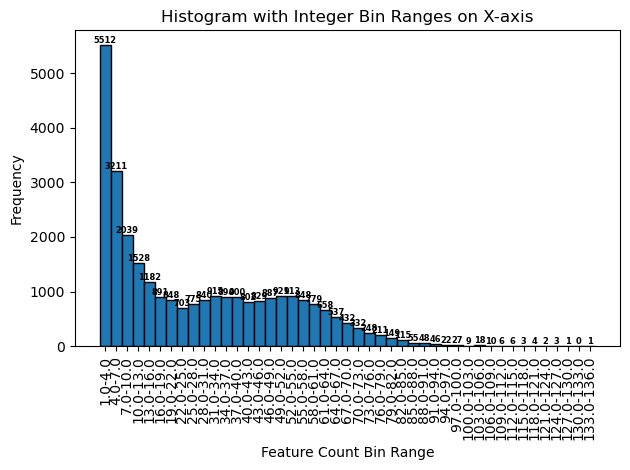

In [22]:

data = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fp))['Total_Feature_Count'].to_list()

# Determine the range of the data
data_min = int(np.floor(min(data)))
data_max = int(np.ceil(max(data)))

# Create integer bin edges
bins = range(data_min, data_max+2, 3)  # +2 because range is exclusive of the upper bound

# Histogram
counts, bin_edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Prepare custom labels: "left-right" for each bin
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Bin centers for placing the x-ticks
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set the x-ticks and labels
plt.xticks(bin_centers, bin_labels, rotation=90)

# Add count labels above each bar
for count, center in zip(counts, bin_centers):
    plt.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=6, fontweight='bold')

plt.xlabel("Feature Count Bin Range")
plt.ylabel("Frequency")
plt.title("Histogram with Integer Bin Ranges on X-axis")
plt.tight_layout()
plt.show()

In [13]:
data_max

135

### FN

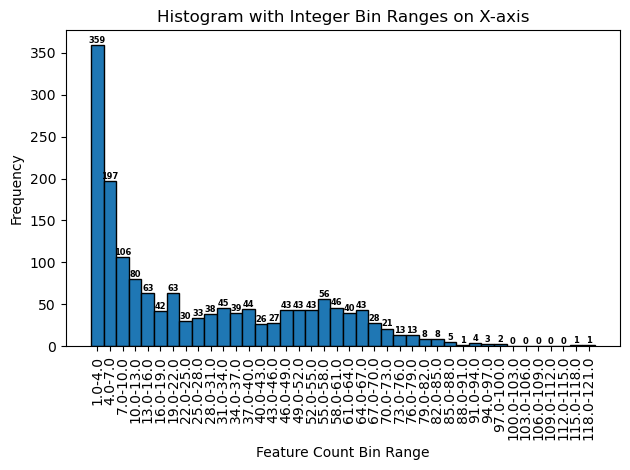

In [23]:
data = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fn))['Total_Feature_Count'].to_list()

# Determine the range of the data
data_min = int(np.floor(min(data)))
data_max = int(np.ceil(max(data)))

# Create integer bin edges
bins = range(data_min, data_max+2, 3)  # +2 because range is exclusive of the upper bound

# Histogram
counts, bin_edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Prepare custom labels: "left-right" for each bin
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Bin centers for placing the x-ticks
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set the x-ticks and labels
plt.xticks(bin_centers, bin_labels, rotation=90)

# Add count labels above each bar
for count, center in zip(counts, bin_centers):
    plt.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=6, fontweight='bold')

plt.xlabel("Feature Count Bin Range")
plt.ylabel("Frequency")
plt.title("Histogram with Integer Bin Ranges on X-axis")
plt.tight_layout()
plt.show()

In [35]:
rows = ['Feature Count <= 1','Feature Count <= 2','Feature Count <= 3','Feature Count <= 4','Feature Count <= 5']

In [36]:
fp_missing_count_per_threshold = []
fn_missing_count_per_threshold = []
for i in range(1,6):
    fp_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('PATIENT_NUM').is_in(data_test_pids_fp)) & (pl.col('Total_Feature_Count')<= i))))
    fn_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('PATIENT_NUM').is_in(data_test_pids_fn)) & (pl.col('Total_Feature_Count')<= i))))

In [37]:
pl.DataFrame({'feature Count':rows,
             'False Positive ID count': fp_missing_count_per_threshold,
             'False Negative ID count': fn_missing_count_per_threshold})

feature Count,False Positive ID count,False Negative ID count
str,i64,i64
"""Feature Count <= 1""",2554,180
"""Feature Count <= 2""",4844,315
"""Feature Count <= 3""",6490,411
"""Feature Count <= 4""",7729,483
"""Feature Count <= 5""",8777,553


# BMI distribution across TP, TN, FP and FN

In [28]:
bmi_data_fn = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fn))['BMI'].to_list()
bmi_data_fp = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_fp))['BMI'].to_list()
bmi_data_tn = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_tn))['BMI'].to_list()
bmi_data_tp = feature_missing_df.filter(pl.col('PATIENT_NUM').is_in(data_test_pids_tp))['BMI'].to_list()

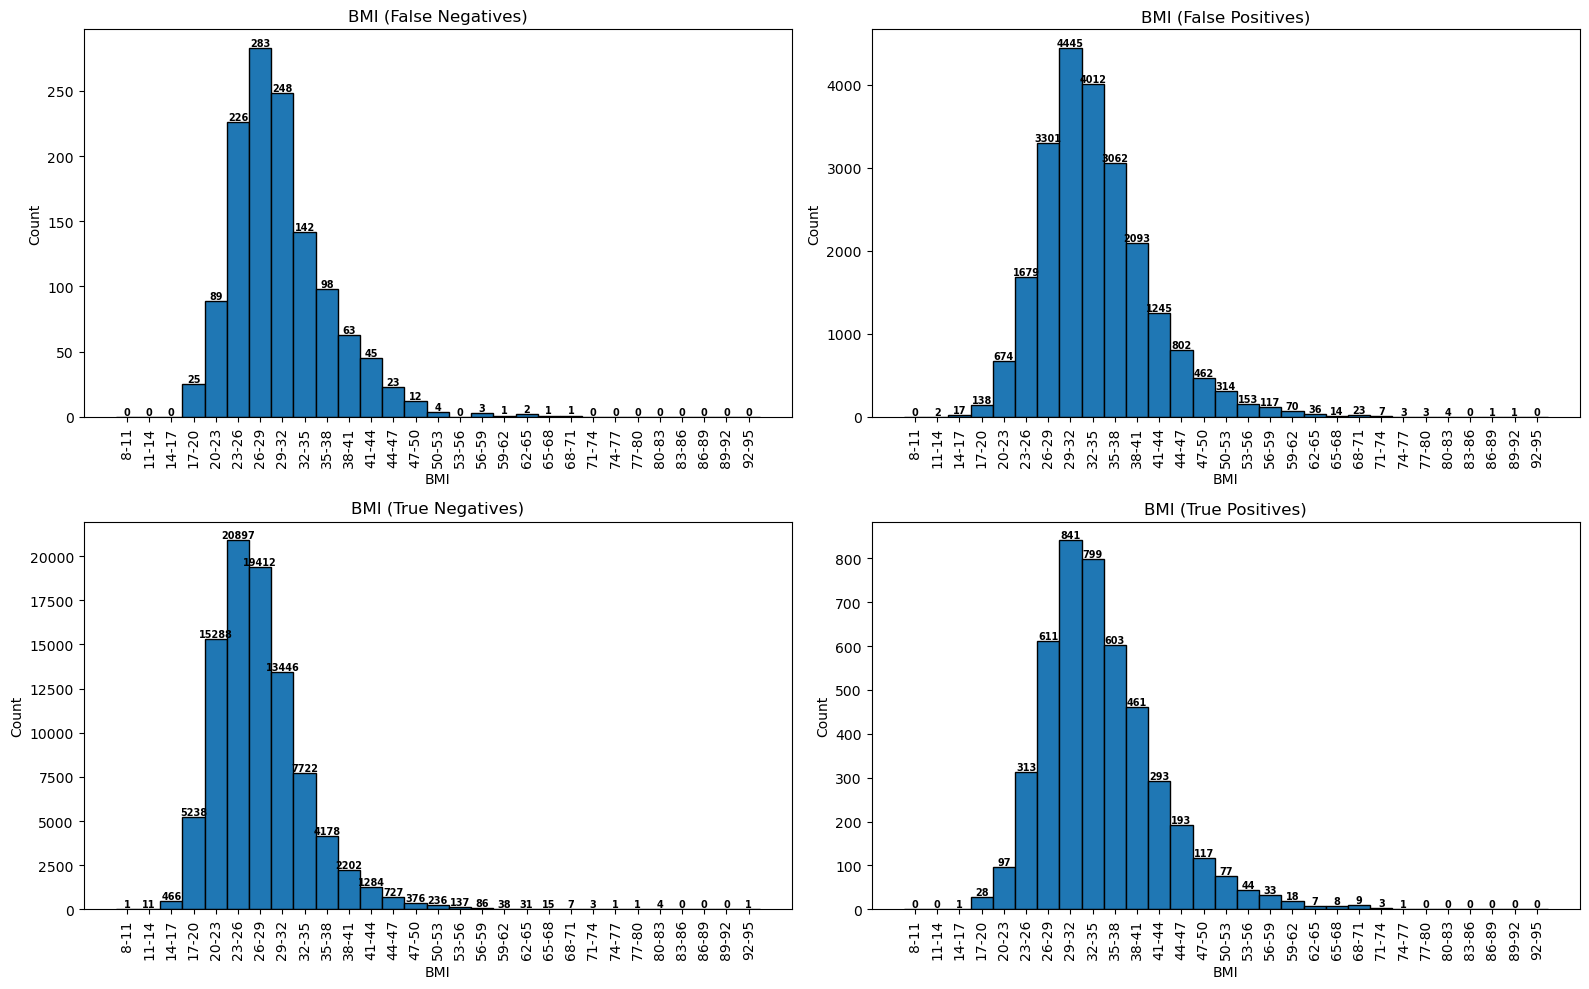

In [36]:
def clean_bmi_data(bmi_list):
    return [x for x in bmi_list if x is not None and not np.isnan(x)]

bmi_data_fn_clean = clean_bmi_data(bmi_data_fn)
bmi_data_fp_clean = clean_bmi_data(bmi_data_fp)
bmi_data_tn_clean = clean_bmi_data(bmi_data_tn)
bmi_data_tp_clean = clean_bmi_data(bmi_data_tp)

all_bmi = bmi_data_fn_clean + bmi_data_fp_clean + bmi_data_tn_clean + bmi_data_tp_clean
min_bmi = int(np.floor(min(all_bmi)))
max_bmi = int(np.ceil(max(all_bmi)))
bin_edges = np.arange(min_bmi, max_bmi + 2, 3)  # +2 to include rightmost bin edge

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

data_list = [bmi_data_fn_clean, bmi_data_fp_clean, bmi_data_tn_clean, bmi_data_tp_clean]
titles = ['BMI (False Negatives)', 'BMI (False Positives)', 'BMI (True Negatives)', 'BMI (True Positives)']

for ax, data, title in zip(axes, data_list, titles):
    counts, edges, patches = ax.hist(data, bins=bin_edges, edgecolor='black')
    # Custom bin labels and centers
    bin_labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(len(edges)-1)]
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(bin_labels, rotation=90)
    # Annotate bars with height
    for count, center in zip(counts, bin_centers):
        ax.text(center, count + 0.1, int(count), ha='center', va='bottom', fontsize=7, fontweight='bold')
    ax.set_title(title)
    ax.set_xlabel('BMI')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('bmi_histograms_fn_fp_tn_tp.png', dpi=300, bbox_inches='tight')
plt.show()

## Distribution across Outcome 1 and 0

In [38]:
print("Number of data points with Outcome 0: ",len(feature_missing_df.filter(pl.col('Outcome')==0)))
print("Number of data points with Outcome 1: ", len(feature_missing_df.filter(pl.col('Outcome')==1)))

Number of data points with Outcome 0:  783552
Number of data points with Outcome 1:  40128


In [39]:
rows = ['Feature Count <= 1','Feature Count <= 2','Feature Count <= 3','Feature Count <= 4','Feature Count <= 5']

In [40]:
Outcome0_missing_count_per_threshold = []
Outcome1_missing_count_per_threshold = []
for i in range(1,6):
    Outcome0_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Outcome') == 0) & (pl.col('Total_Feature_Count')<= i))))
    Outcome1_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Outcome') == 1) & (pl.col('Total_Feature_Count')<= i))))

In [41]:
pl.DataFrame({'feature Count':rows,
             'Outcome 0 ID count': Outcome0_missing_count_per_threshold,
             'Outcome 1 ID count': Outcome1_missing_count_per_threshold})

feature Count,Outcome 0 ID count,Outcome 1 ID count
str,i64,i64
"""Feature Count <= 1""",104850,5907
"""Feature Count <= 2""",165333,8969
"""Feature Count <= 3""",210486,11039
"""Feature Count <= 4""",246639,12457
"""Feature Count <= 5""",277147,13614


## Distribution of low count feature data points in data_test and data_train pids

In [61]:
# Open the file in binary mode 
with open('./Determine_models_running_folder/train_data_pids.pkl', 'rb') as file: 
    train_pids = pickle.load(file) 
with open('./Determine_models_running_folder/test_data_pids.pkl', 'rb') as file: 
    test_pids = pickle.load(file) 

In [63]:
print("Number of data points in the train pids",len(train_pids))
print("Number of data points in the test pids",len(test_pids))

Number of data points in the train pids 833965
Number of data points in the test pids 208492


In [75]:
rows = ['Feature Count <= 1','Feature Count <= 2','Feature Count <= 3','Feature Count <= 4','Feature Count <= 5']

In [77]:
train_pids_missing_count_per_threshold = []
test_pids_missing_count_per_threshold = []
for i in range(1,6):
    train_pids_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Outcome').is_in(train_pids)) & (pl.col('Total_Feature_Count')<= i))))
    test_pids_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Outcome').is_in(test_pids)) & (pl.col('Total_Feature_Count')<= i))))

In [80]:
pl.DataFrame({'feature Count':rows,
             'Train ID count': Outcome0_missing_count_per_threshold,
             'Test ID count': Outcome1_missing_count_per_threshold})

feature Count,Train ID count,Test ID count
str,i64,i64
"""Feature Count <= 1""",127595,5593
"""Feature Count <= 2""",201313,8897
"""Feature Count <= 3""",257007,11286
"""Feature Count <= 4""",301618,13140
"""Feature Count <= 5""",339335,14641


## Distribution across Gender Identity

In [81]:
feature_missing_df.head()

PATIENT_NUM,lab_feature_count,med_feature_count,dx_feature_count,Total_Feature_Count,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Sex_CD,Race_CD,Hispanic_CD,Gender_CD
i64,i32,i32,i32,i32,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str,str,str,str
8388608,37,0,0,37,2018-04-25 00:00:00,null,52,0,null,"""94619""","""M""","""02""","""N""","""M"""
8388609,32,0,1,33,2019-03-18 00:00:00,null,23,0,null,"""93306""","""F""","""UN""","""Y""","""W"""
8388610,0,0,1,1,2019-03-18 00:00:00,2019-09-18 00:00:00,46,1,null,"""94804""","""F""","""05""","""Y""","""W"""
4194311,48,2,5,55,2018-07-05 00:00:00,null,31,0,null,"""90805""","""F""","""UN""","""N""","""UN"""
8388618,5,0,5,10,2019-04-22 00:00:00,null,36,0,null,"""55407""","""F""","""05""","""Y""","""W"""


In [87]:
unique_gender_cd =np.unique(feature_missing_df['Gender_CD'].to_list(), return_counts = True)
unique_gender_cd

(array(['GQ', 'M', 'OT', 'TG', 'UN', 'W'], dtype='<U2'),
 array([  2376, 301073,   1185,   4198, 229584, 504156]))

In [88]:
pl.DataFrame({'Gender': unique_gender_cd[0],
             'Count':unique_gender_cd[1]})

Gender,Count
str,i64
"""GQ""",2376
"""M""",301073
"""OT""",1185
"""TG""",4198
"""UN""",229584
"""W""",504156


In [85]:
GQ_missing_count_per_threshold = []
M_missing_count_per_threshold = []
OT_missing_count_per_threshold = []
TG_missing_count_per_threshold = []
UN_missing_count_per_threshold = []
W_missing_count_per_threshold = []

for i in range(1,6):
    GQ_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='GQ') & (pl.col('Total_Feature_Count')<= i))))
    M_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='M') & (pl.col('Total_Feature_Count')<= i))))
    OT_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='OT') & (pl.col('Total_Feature_Count')<= i))))
    TG_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='TG') & (pl.col('Total_Feature_Count')<= i))))
    UN_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='UN') & (pl.col('Total_Feature_Count')<= i))))
    W_missing_count_per_threshold.append(len(feature_missing_df.filter((pl.col('Gender_CD')=='W') & (pl.col('Total_Feature_Count')<= i))))

In [86]:
pl.DataFrame({'feature Count':rows,
             'GQ Gender count': GQ_missing_count_per_threshold,
             'M Gender count': M_missing_count_per_threshold,
             'OT Gender count': OT_missing_count_per_threshold,
             'TG Gender count': TG_missing_count_per_threshold,
             'UN Gender count': UN_missing_count_per_threshold,
             'W Gender count': W_missing_count_per_threshold,})

feature Count,GQ Gender count,M Gender count,OT Gender count,TG Gender count,UN Gender count,W Gender count
str,i64,i64,i64,i64,i64,i64
"""Feature Count <= 1""",218,35720,98,292,41662,55198
"""Feature Count <= 2""",357,56828,152,514,63856,88503
"""Feature Count <= 3""",491,73240,212,697,79976,113677
"""Feature Count <= 4""",570,86223,261,842,92437,134425
"""Feature Count <= 5""",666,97198,306,949,102825,152032
